<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам


In [1]:
# Импорт библиотек

import pandas as pd
import numpy as np
import re
import seaborn as sns
from numpy import percentile
from itertools import combinations
from scipy.stats import ttest_ind
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif
from seaborn import countplot
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
import warnings
import os
import sys
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor, cv, Pool
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Setup

In [6]:
VERSION    = 16
DIR_TRAIN  = '../input/auto-ru-01-02-2021/' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# Data

In [7]:
!ls '../input'

auto-ru-01-02-2021  sf-dst-car-price-prediction


In [8]:
train = pd.read_csv(DIR_TRAIN+'all_auto_ru_01_02_2021.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [9]:
train.head(5)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,0000CC,бензин,1990.0,2.3 MT (133 л.с.),4.0,1993,SEDAN MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,93000.0,2021-01-07T10:58:58Z,NaN,100
1,Седан,AUDI,4A2197,бензин,1990.0,2.3 MT (133 л.с.),4.0,1993,SEDAN MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,4.0,DUPLICATE,True,"{'year': 2018, 'month': 6}",155000.0,2021-01-30T03:34:16Z,NaN,100
2,Седан,AUDI,040001,бензин,1990.0,2.3 MT (133 л.с.),4.0,1991,SEDAN MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,"{'year': 2020, 'month': 8}",180000.0,2020-11-08T17:23:26Z,NaN,100
3,Универсал 5 дв.,AUDI,EE1D19,бензин,1990.0,2.0 MT (115 л.с.),5.0,1994,WAGON_5_DOORS MECHANICAL 2.0,MECHANICAL,...,LEFT,NaN,2.0,ORIGINAL,True,"{'year': 2004, 'month': 11}",192000.0,2020-12-04T08:37:24Z,NaN,100
4,Седан,AUDI,EE1D19,бензин,1990.0,2.0 MT (115 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,...,LEFT,NaN,3.0,DUPLICATE,True,NaN,130000.0,2020-07-18T09:51:29Z,NaN,100


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65351 entries, 0 to 65350
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              65349 non-null  object 
 1   brand                 65351 non-null  object 
 2   color                 65351 non-null  object 
 3   fuelType              65351 non-null  object 
 4   modelDate             65349 non-null  float64
 5   name                  65349 non-null  object 
 6   numberOfDoors         65349 non-null  float64
 7   productionDate        65351 non-null  int64  
 8   vehicleConfiguration  65349 non-null  object 
 9   vehicleTransmission   65349 non-null  object 
 10  engineDisplacement    65349 non-null  object 
 11  enginePower           65349 non-null  float64
 12  description           62631 non-null  object 
 13  mileage               65351 non-null  int64  
 14  Комплектация          65351 non-null  object 
 15  Привод             

In [11]:
train.isna().sum()

bodyType                    2
brand                       0
color                       0
fuelType                    0
modelDate                   2
name                        2
numberOfDoors               2
productionDate              0
vehicleConfiguration        2
vehicleTransmission         2
engineDisplacement          2
enginePower                 2
description              2720
mileage                     0
Комплектация                0
Привод                      2
Руль                        0
Состояние               65351
Владельцы               12120
ПТС                       374
Таможня                     0
Владение                49173
price                     264
start_date                  0
hidden                  65351
model                       0
dtype: int64

In [12]:
# удалим столбцы с большим количеством пропусков:
train.drop(['Состояние', 'Владельцы', 'description','hidden', 'Владение'], axis=1, inplace=True)
# смотря на количество пропусков относительно числа общих данных я считаю, что можно смело удалять пропуски
train.dropna(inplace=True)
# переименуем стоблец model на model_name, для удобства дальнейшей работы
train.rename(columns={'model': 'model_name'}, inplace=True)
# также мы видимо, что колонка Таможня имеет булевой тип, изменим это
train['Таможня'] = train['Таможня'].map({True: 'Растаможен', False:'Не растаможен'})

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64711 entries, 0 to 65350
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              64711 non-null  object 
 1   brand                 64711 non-null  object 
 2   color                 64711 non-null  object 
 3   fuelType              64711 non-null  object 
 4   modelDate             64711 non-null  float64
 5   name                  64711 non-null  object 
 6   numberOfDoors         64711 non-null  float64
 7   productionDate        64711 non-null  int64  
 8   vehicleConfiguration  64711 non-null  object 
 9   vehicleTransmission   64711 non-null  object 
 10  engineDisplacement    64711 non-null  object 
 11  enginePower           64711 non-null  float64
 12  mileage               64711 non-null  int64  
 13  Комплектация          64711 non-null  object 
 14  Привод                64711 non-null  object 
 15  Руль               

In [14]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

## Data Preprocessing

In [16]:
train.dropna(subset=['productionDate','mileage'], inplace=True)
train.dropna(subset=['price'], inplace=True)

In [17]:
#приведем эти колонки к числовому виду
num_fields = ['modelDate', 'productionDate', 'numberOfDoors', 'mileage']
for col in num_fields:
    train[col] = train[col].astype('int64')

In [18]:
#добавим признак 'vendor'
euro = ['BMW', 'VOLKSWAGEN', 'MERCEDES', 'AUDI', 'SKODA', 'VOLVO']
train['vendor'] = train['brand'].apply(lambda x: 'EUROPEAN' if x in euro else 'JAPANESE')
test['vendor'] = test['brand'].apply(lambda x: 'EUROPEAN' if x in euro else 'JAPANESE')

In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [20]:
# создадим списки числовых и категориальных признаков 
num_f = ['modelDate', 'productionDate', 'mileage', 'numberOfDoors']
cat_f = ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'vehicleConfiguration', 'enginePower', 'engineDisplacement',
         'vehicleTransmission', 'vendor']

In [21]:
# напишем функции визуализации и поиска выбросов



class AnalyzNumCol():
    def __init__(self, df, col):
        self.df = df[col]
        self.col = col
        self.col_log = LogDf(df, col).col_log
        self.df_log = LogDf(df, col).df_col_log()
    
    def show_plots(self, size = 5, log = False):
        
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col
        
        f = plt.figure()
        f.clear()
        plt.close(f)

        fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (3*size,size))
        
        
        ax1.hist(data.dropna(), bins = 20, histtype = 'bar', align = 'mid', rwidth = 0.8, color = 'red')
       
        
        
        
        ax3.boxplot(data.dropna(), vert = False)  # выбросы
     
        plt.show
        
    def emission_limits(self, log = False): # границы выбросов
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col
        
        q1 = data.quantile(q = 0.25) 
        q3 = data.quantile(q = 0.75) 
        IQR = q3 - q1
        return q1 - 1.5*IQR, q3 + 1.5*IQR

    def amount_emissions(self, log = False): 
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col

        minb, maxb = self.emission_limits(log)
        return len(data[data < minb])+ len(data[data > maxb])

    
# класс логарифмирования признака
    
class LogDf(): 
    def __init__(self, df, col):
        self.df = df
        self.col = col
        self.col_log = col + '_log'
        
    def df_col_log(self):      
        return  self.df[self.col].apply(lambda x: np.log(x + 1))

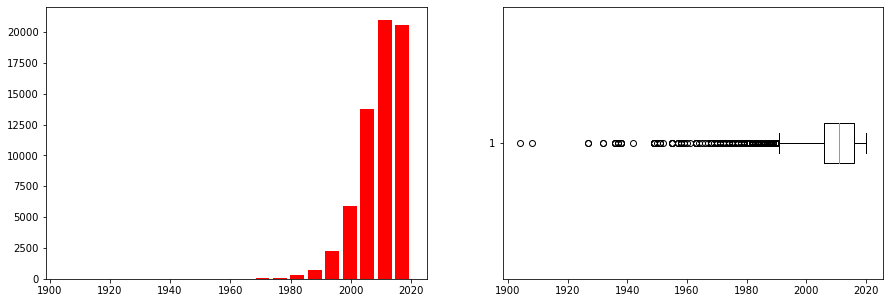

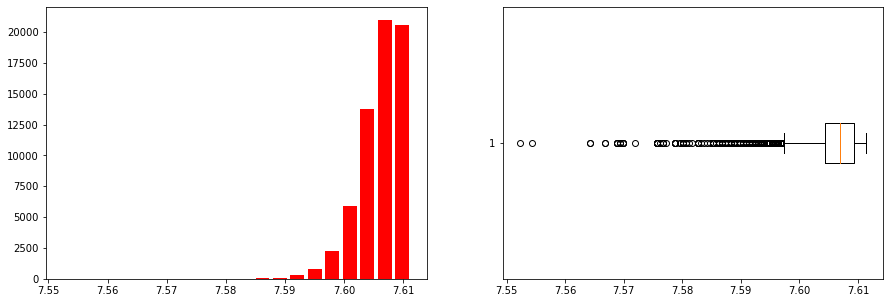

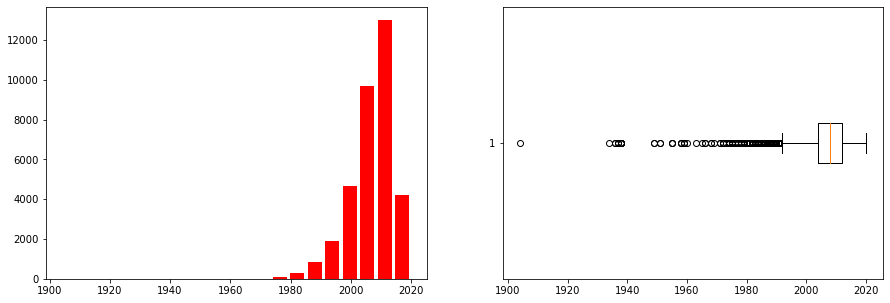

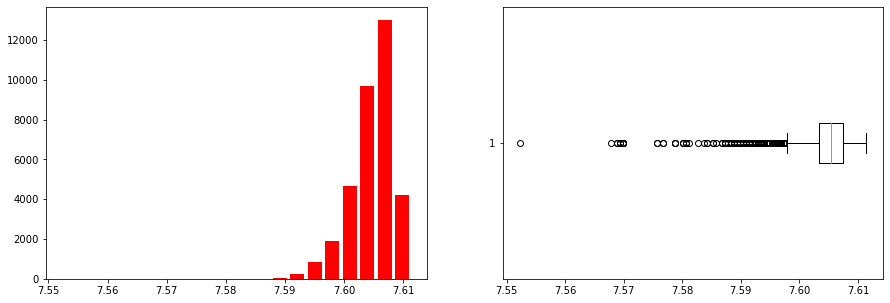

In [22]:
modelDate = AnalyzNumCol(train, 'modelDate')
modelDate.show_plots()
modelDate.show_plots(log = True)
modelDate = AnalyzNumCol(test, 'modelDate')
modelDate.show_plots()
modelDate.show_plots(log = True)

Мы видим много выбросов снизу, однако убирать их не будем, так как там могут быть специфичные модели машин. Логарифмирование делу не помогло, идем дальше

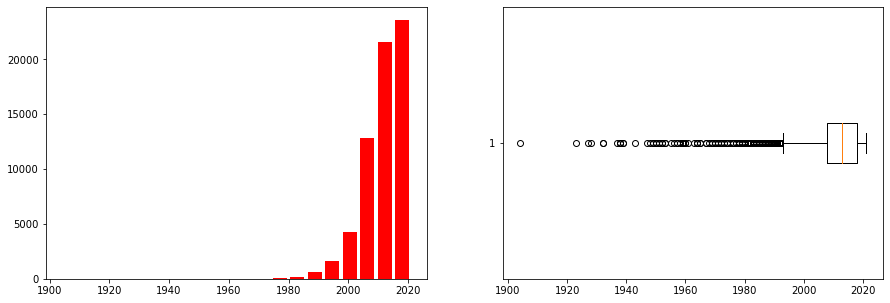

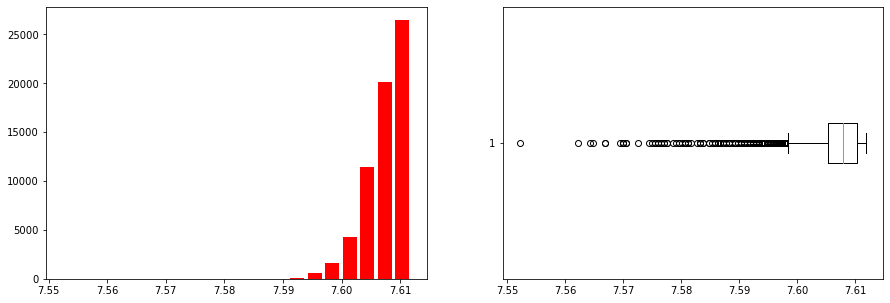

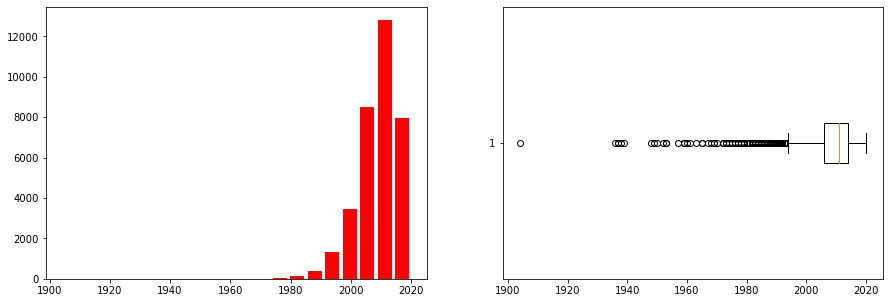

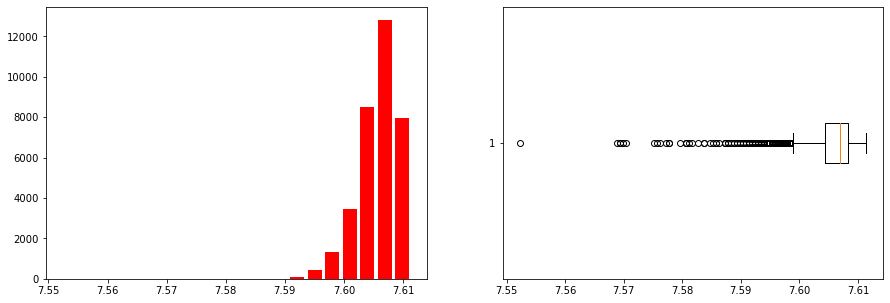

In [23]:
productionDate = AnalyzNumCol(train, 'productionDate')
productionDate.show_plots()
productionDate.show_plots(log = True)
productionDate = AnalyzNumCol(test, 'productionDate')
productionDate.show_plots()
productionDate.show_plots(log = True)

Не помогает, смотрим еще


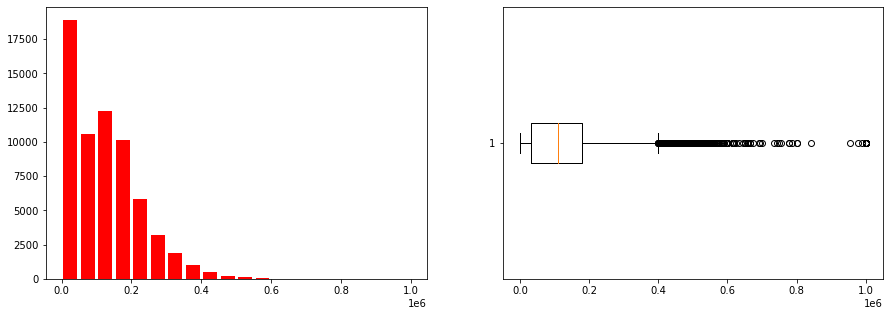

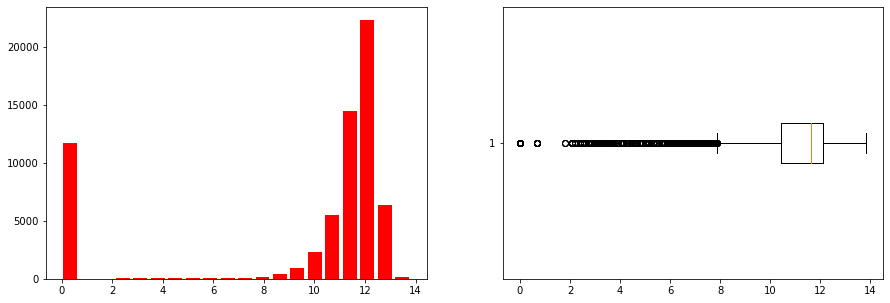

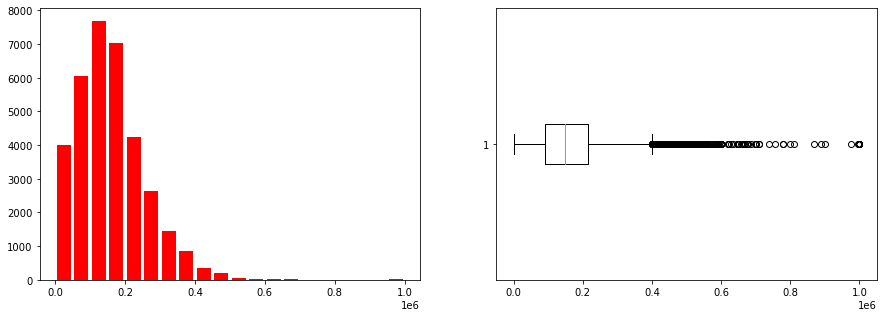

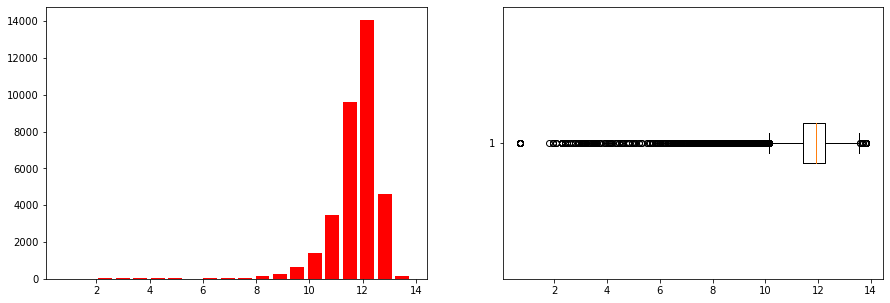

In [24]:
mileage = AnalyzNumCol(train, 'mileage')
mileage.show_plots()
mileage.show_plots(log = True)
mileage = AnalyzNumCol(test, 'mileage')
mileage.show_plots()
mileage.show_plots(log = True)

График не становится более стабильным ахах

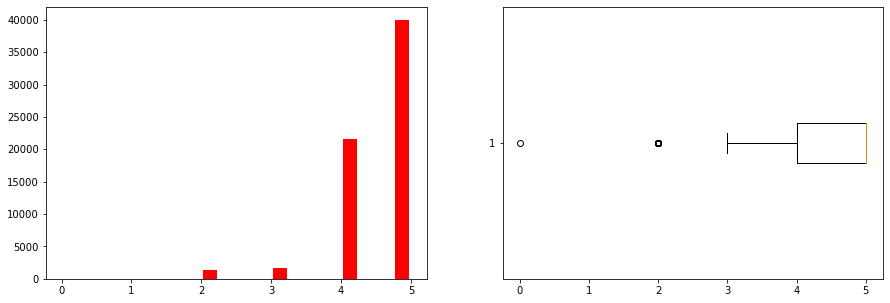

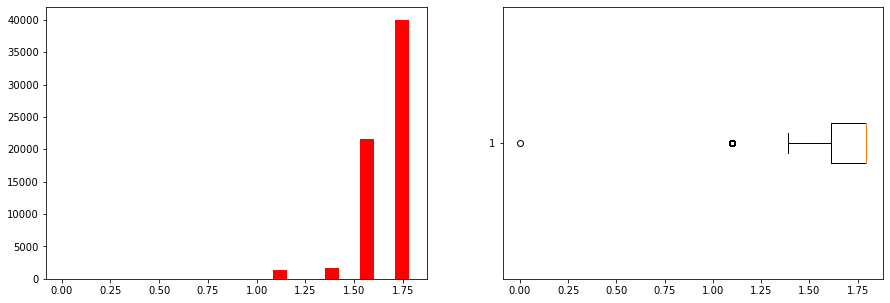

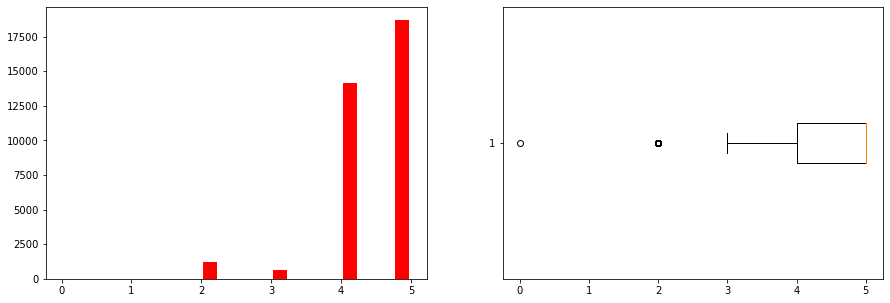

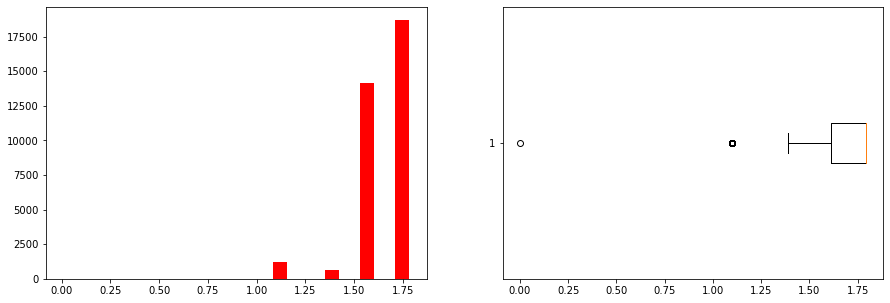

In [25]:
numberOfDoors = AnalyzNumCol(train, 'numberOfDoors')
numberOfDoors.show_plots()
numberOfDoors.show_plots(log = True)
numberOfDoors = AnalyzNumCol(test, 'numberOfDoors')
numberOfDoors.show_plots()
numberOfDoors.show_plots(log = True)

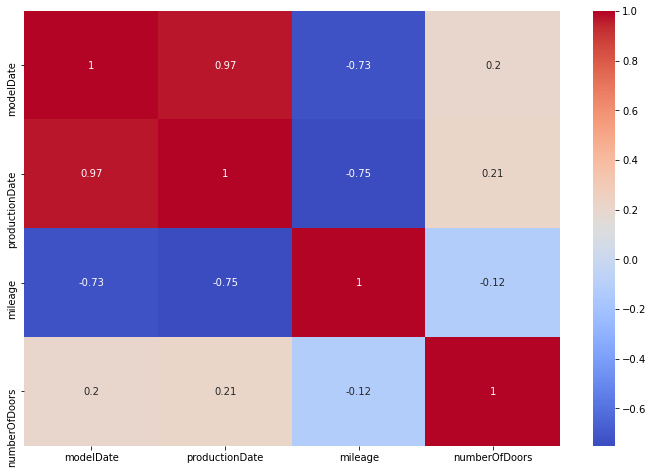

In [26]:
# Посмотрим корреляцию числовых признаков
correlation = train[num_f].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

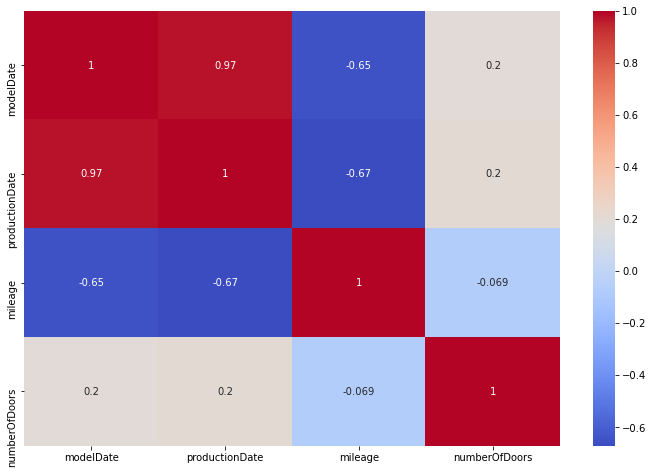

In [27]:
# Посмотрим корреляцию числовых признаков
correlation = test[num_f].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Выводы по рассмотрению корреляции числовых признаков: наблюдаем сильную зависимость года выпуска и года модели, надо что-то убирать
Также сильна корреляция по пробегу и году выпуска/модели, что неудивительно

In [28]:
for col in cat_f:
    print(col, train[col].nunique(), '\n', train[col].value_counts()[:3], '\n')

bodyType 161 
 Внедорожник 5 дв.    25709
Седан                19432
Хэтчбек 5 дв.         5717
Name: bodyType, dtype: int64 

brand 36 
 MERCEDES      7763
BMW           5949
VOLKSWAGEN    4485
Name: brand, dtype: int64 

color 16 
 040001    17756
FAFBFB    12535
97948F     8437
Name: color, dtype: int64 

fuelType 5 
 бензин    52776
дизель    11657
гибрид      185
Name: fuelType, dtype: int64 

model_name 1037 
 FOCUS      1396
5ER        1339
SOLARIS    1153
Name: model_name, dtype: int64 

vehicleConfiguration 1680 
 SEDAN MECHANICAL 1.6             2535
ALLROAD_5_DOORS AUTOMATIC 2.0    2315
SEDAN AUTOMATIC 1.6              2229
Name: vehicleConfiguration, dtype: int64 



KeyError: 3

In [29]:
for col in cat_f:
    print(col, test[col].nunique(), '\n', test[col].value_counts()[:3], '\n')

bodyType 24 
 седан                13147
внедорожник 5 дв.    12228
лифтбек               2232
Name: bodyType, dtype: int64 

brand 12 
 BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
Name: brand, dtype: int64 

color 16 
 чёрный         11010
белый           6133
серебристый     4113
Name: color, dtype: int64 

fuelType 5 
 бензин    28601
дизель     5800
гибрид      223
Name: fuelType, dtype: int64 

model_name 544 
 OCTAVIA    1418
5ER        1026
LANCER      855
Name: model_name, dtype: int64 

vehicleConfiguration 634 
 ALLROAD_5_DOORS AUTOMATIC 3.0    2389
SEDAN AUTOMATIC 2.0              1610
ALLROAD_5_DOORS AUTOMATIC 2.0    1327
Name: vehicleConfiguration, dtype: int64 

enginePower 315 
 249 N12    1708
150 N12    1699
110 N12    1039
Name: enginePower, dtype: int64 

engineDisplacement 55 
 2.0 LTR    7391
1.6 LTR    4973
3.0 LTR    3915
Name: engineDisplacement, dtype: int64 

vehicleTransmission 4 
 автоматическая    19596
механическая       7209
вариатор         

In [30]:
#Создадим бинарный категориальный признак "allroad" - наличие полного привода:
train['allroad'] = train['vehicleConfiguration'].apply(lambda x: 1 if x.split('_')[0] == 'ALLROAD' else 0)
test['allroad'] = test['vehicleConfiguration'].apply(lambda x: 1 if x.split('_')[0] == 'ALLROAD' else 0)
cat_f.append('allroad')

In [31]:
train['model_age'] = train['productionDate'] - train['modelDate']
train['model_age'] = train['model_age'].apply(lambda x: 0 if x < 0 else x)
test['model_age'] = test['productionDate'] - test['modelDate']
test['model_age'] = test['model_age'].apply(lambda x: 0 if x < 0 else x)
num_f.append('model_age')

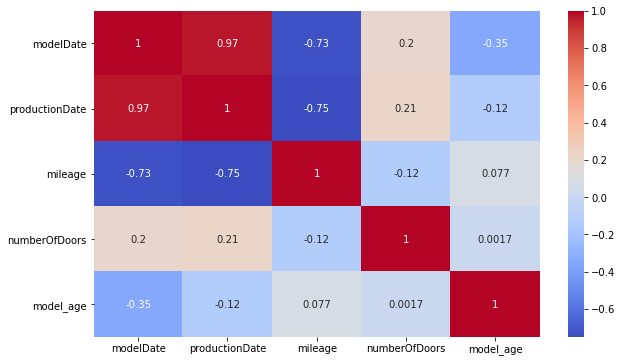

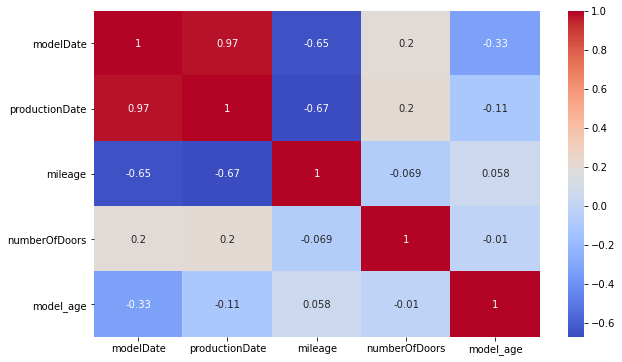

In [32]:
correlation = train[num_f].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
correlation = test[num_f].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [33]:
# возьмём схожих признаков без полной обработки
columns = ['bodyType', 'brand', 'productionDate', 'engineDisplacement', 'mileage', 'vendor', 'allroad', 'model_age']
df_train = train[columns]
df_test = test[columns]

In [34]:
y = train['price']

## Label Encoding

In [35]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [36]:
for colum in ['bodyType', 'brand', 'engineDisplacement', 'vendor', 'allroad']:
    data[colum] = data[colum].astype('category').cat.codes

In [37]:
data

,bodyType,brand,productionDate,engineDisplacement,mileage,vendor,allroad,model_age,sample
0,169,29,2014,12,74000,0,0,1,0
1,169,29,2017,27,60563,0,0,0,0
2,169,29,2014,33,88000,0,0,1,0
3,169,29,2014,27,95000,0,0,1,0
4,169,29,2012,33,58536,0,0,4,0
...,...,...,...,...,...,...,...,...,...
99392,56,30,2006,95,260000,1,0,2,1
99393,56,30,2013,72,96132,1,0,0,1
99394,56,30,2013,72,148000,1,0,0,1
99395,56,30,2014,72,133357,1,0,1,1


In [38]:
X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

## Train Split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [40]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [41]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 160.18%


# # Model 2 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Fit

In [42]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [43]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 17.12%


Вот так просто со старта, даже не трогая сами данные и не подбирая настройки catboosta, получаем модель с уровнем ошибки в 17%!

### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    


In [44]:
np.log(y_train)

64913    11.918391
24839    13.399995
42033    12.506177
46925    13.017003
9505     13.670485
           ...    
63190    16.192275
38549    13.262125
868      13.384728
15936    13.038982
56943    13.652992
Name: price, Length: 51768, dtype: float64

In [45]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')

In [46]:
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

In [47]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.99%


Как видим точность возросла до 14%, а что будет на ЛБ?

Стэкинг

Поскольку кэтбуст дал нам хороший результат, попробуем его еще и улучшить. Для этого добавим алгоритм рандомного леса и градиентного бустинга. Посмотрим, что получится

In [48]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor




estimators=[
        ('rf', RandomForestRegressor(random_state=RANDOM_SEED, 
                                      n_estimators=200, min_samples_split=2, 
                                      min_samples_leaf=2, 
                                      max_features='auto', max_depth=5, 
                                      bootstrap=True, n_jobs=-1)),
        ('gbr', GradientBoostingRegressor(n_estimators=1000, random_state=RANDOM_SEED,  
                                          )),
        ('сbr',  CatBoostRegressor(iterations = 2000,
                                   learning_rate = 0.062,
                                   random_seed = RANDOM_SEED,
                                   eval_metric='MAPE',
                                   custom_metric=['R2', 'MAE'],
                                   depth=10,
                                   l2_leaf_reg=1)
        )
            ]

sr = StackingRegressor(estimators=estimators,
                       final_estimator = GradientBoostingRegressor(n_estimators=500, 
                                                                   random_state=RANDOM_SEED))

In [49]:
sr.fit(X_train, np.log1p(y_train))

0:	learn: 0.0590788	total: 28.6ms	remaining: 57.1s
1:	learn: 0.0559347	total: 50.4ms	remaining: 50.3s
2:	learn: 0.0529836	total: 69.4ms	remaining: 46.2s
3:	learn: 0.0502325	total: 88.1ms	remaining: 44s
4:	learn: 0.0477183	total: 110ms	remaining: 44s
5:	learn: 0.0453390	total: 132ms	remaining: 44s
6:	learn: 0.0431150	total: 156ms	remaining: 44.4s
7:	learn: 0.0410685	total: 176ms	remaining: 43.9s
8:	learn: 0.0391065	total: 197ms	remaining: 43.7s
9:	learn: 0.0373102	total: 218ms	remaining: 43.4s
10:	learn: 0.0356654	total: 239ms	remaining: 43.2s
11:	learn: 0.0341093	total: 263ms	remaining: 43.6s
12:	learn: 0.0326887	total: 285ms	remaining: 43.5s
13:	learn: 0.0312933	total: 313ms	remaining: 44.5s
14:	learn: 0.0300450	total: 340ms	remaining: 45s
15:	learn: 0.0288941	total: 365ms	remaining: 45.2s
16:	learn: 0.0277837	total: 388ms	remaining: 45.2s
17:	learn: 0.0267314	total: 410ms	remaining: 45.1s
18:	learn: 0.0258067	total: 431ms	remaining: 44.9s
19:	learn: 0.0249657	total: 456ms	remaining: 

StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_depth=5,
                                                     min_samples_leaf=2,
                                                     n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=42)),
                              ('gbr',
                               GradientBoostingRegressor(n_estimators=1000,
                                                         random_state=42)),
                              ('сbr',
                               <catboost.core.CatBoostRegressor object at 0x7fd2eaab5c50>)],
                  final_estimator=GradientBoostingRegressor(n_estimators=500,
                                                            random_state=42))

In [50]:
predict_test = np.expm1(sr.predict(X_test))
predict_submission = np.expm1(sr.predict(X_sub))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.66%


Точность стала 13.66% Неплохо!

# Submission

In [51]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}_stack.csv', index=False)
sample_submission.head(10)





,sell_id,price
0,1100575026,5.676841e+05
1,1100549428,9.593113e+05
2,1100658222,9.244902e+05
3,1100937408,6.909636e+05
4,1101037972,6.582048e+05
5,1100912634,6.582837e+05
6,1101228730,6.910634e+05
7,1100165896,4.059573e+05
8,1100768262,1.371194e+06
9,1101218501,8.151282e+05
